### <span style="color:orange">**XGBoost**</span>를 사용한 train data 모델링

Boositing 기법

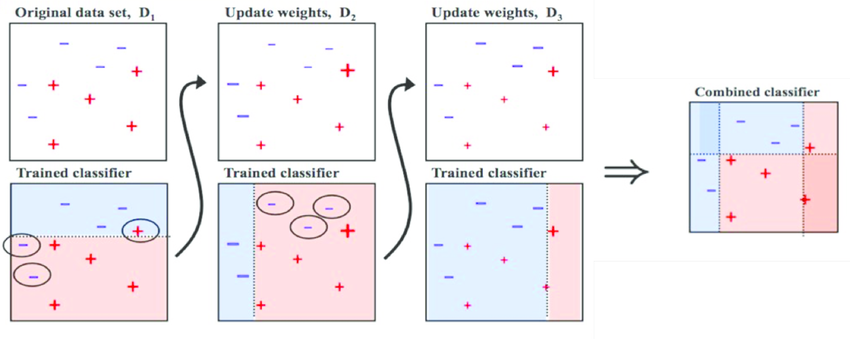

- 이전 예측 모델의 성능을 보완하는 새로운 예측 모델을 만들어 정확도 높이는 방법
- 한번 학습이 끝나면 약한 모델에 가중치 부여 >> 학습 어려운 샘플을 더 잘 맞추도록 학습
- 이상치에 약하며, 과적합(over-fitting)될 가능성이 높음

Ada Boost
- 이전 약한 모델의 잔차를 바탕으로 가중치를 부여한 새로운 모델 만듦

Gradient Boost
- 이전 약한 모델의 잔차를 다음 모델에서 처리하면서 약한 모델을 순차적으로 학습

XGBoost (Extreme Gradient Boosting)
- 규제를 지원하여 모델의 과적합을 방지하고 일반화 성능 높임, Ridge가 기본값으로 1로 지정되어있음

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
train = pd.read_csv('../future_sales.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'main_type_id', 'sub_type_id', 'city_id', 'year',
       'month', 'day', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_cnt_month_mean_lag_1', 'date_shop_month_mean_lag_1',
       'date_shop_month_mean_lag_2', 'date_shop_month_mean_lag_3',
       'date_shop_month_mean_lag_6', 'date_shop_month_mean_lag_12',
       'date_item_month_mean_lag_1', 'date_item_month_mean_lag_2',
       'date_item_month_mean_lag_3', 'date_item_month_mean_lag_6',
       'date_item_month_mean_lag_12', 'date_cat_month_mean_lag_1',
       'date_shop_cat_month_mean_lag_1', 'date_shop_type_month_mean_lag_1',
       'date_shop_subtype_month_mean_lag_1', 'date_city_month_mean_lag_1',
       'date_city_item_month_mean_lag_1', 'date_type_month_mean_lag_1',
       'date_subtype_month_mean_lag_1'],
      dtype='object')

In [4]:
# train, validation, test 데이터 3가지로 나누기
# X는 'item_cnt_month'를 제외한 모든 컬럼 추가, y는 'item_cnt_month'만 추가

X_train = train[train['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = train[train['date_block_num'] < 33]['item_cnt_month']

X_val = train[train['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_val = train[train['date_block_num'] == 33]['item_cnt_month']

X_test = train[train['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

# y_test의 값을 예측해야함

In [36]:
# XGBoost model parameter 조정
model = XGBRegressor(
    max_depth = 8,
    n_estimators = 500,
    learning_rate = 0.1,
    min_child_weight = 300,
    colsample_bytree = 0.6,
    subsample = 0.8,
    gamma = 0.3,
    eta = 0.1,
    eval_metric = 'rmse',
    early_stopping_rounds = 20,
    seed = 42
    )

# 모델 훈련
model.fit(X_train,y_train,
          eval_set = [(X_train, y_train), (X_val, y_val)],
          # train과 validation에 대한 모델 성능의 변화를 확인
          verbose = True
          )

y_pred = model.predict(X_val).clip(0,20)
y_test = model.predict(X_test).clip(0,20)

# early_stopping_rounds를 통해 모델의 베스트 결과값을 출력
print('Number :', model.best_iteration, '\nRMSE :', model.best_score)

[0]	validation_0-rmse:1.03167	validation_1-rmse:1.06876
[1]	validation_0-rmse:0.98948	validation_1-rmse:1.03514
[2]	validation_0-rmse:0.95072	validation_1-rmse:1.00549
[3]	validation_0-rmse:0.91765	validation_1-rmse:0.97984
[4]	validation_0-rmse:0.89021	validation_1-rmse:0.95991
[5]	validation_0-rmse:0.86725	validation_1-rmse:0.94300
[6]	validation_0-rmse:0.84727	validation_1-rmse:0.92827
[7]	validation_0-rmse:0.83076	validation_1-rmse:0.91677
[8]	validation_0-rmse:0.81690	validation_1-rmse:0.90756
[9]	validation_0-rmse:0.80533	validation_1-rmse:0.89994
[10]	validation_0-rmse:0.79524	validation_1-rmse:0.89344
[11]	validation_0-rmse:0.78616	validation_1-rmse:0.88824
[12]	validation_0-rmse:0.77855	validation_1-rmse:0.88420
[13]	validation_0-rmse:0.77239	validation_1-rmse:0.88097
[14]	validation_0-rmse:0.76748	validation_1-rmse:0.87817
[15]	validation_0-rmse:0.76306	validation_1-rmse:0.87608
[16]	validation_0-rmse:0.75929	validation_1-rmse:0.87405
[17]	validation_0-rmse:0.75588	validation

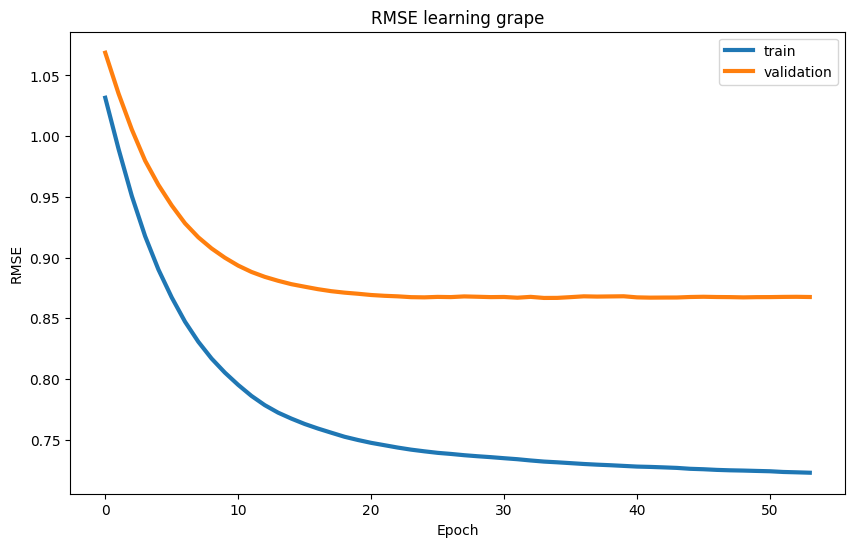

In [37]:
# 평가 결과를 가져와서 데이터 시각화
result = model.evals_result()
train_rmse = result['validation_0']['rmse']
val_rmse = result['validation_1']['rmse']
# train과 validation에 대한 rmse 평가를 출력

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='train', linewidth=3)
plt.plot(val_rmse, label='validation', linewidth=3)
plt.title('RMSE learning grape')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# train 데이터는 모델을 계속 학습할수록 rmse가 낮아지고 있지만
# validation 데이터는 어느 순간 감소하지 않고 증가하는 것을 볼 수 있음
# 과적합 문제의 발생으로 early stopping round 파라미터를 활용해 validation 모델 학습을 조기 종료 시키는 방법을 채택

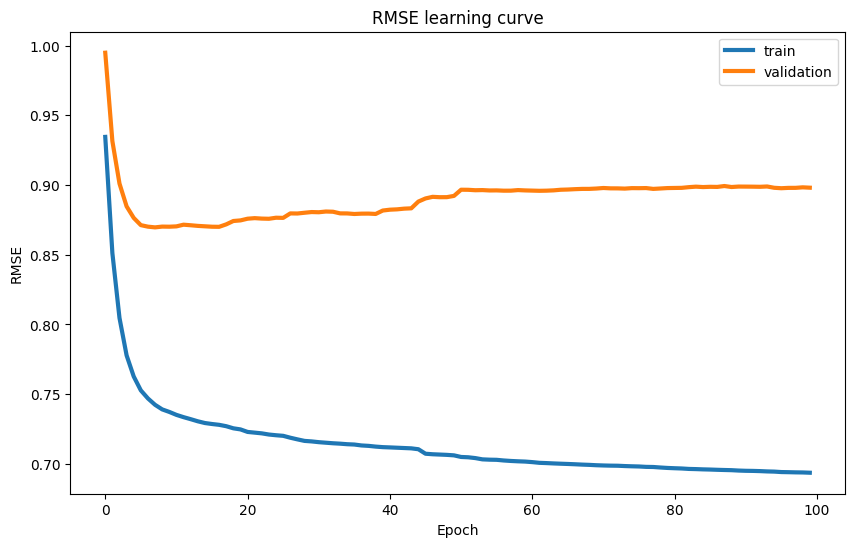

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

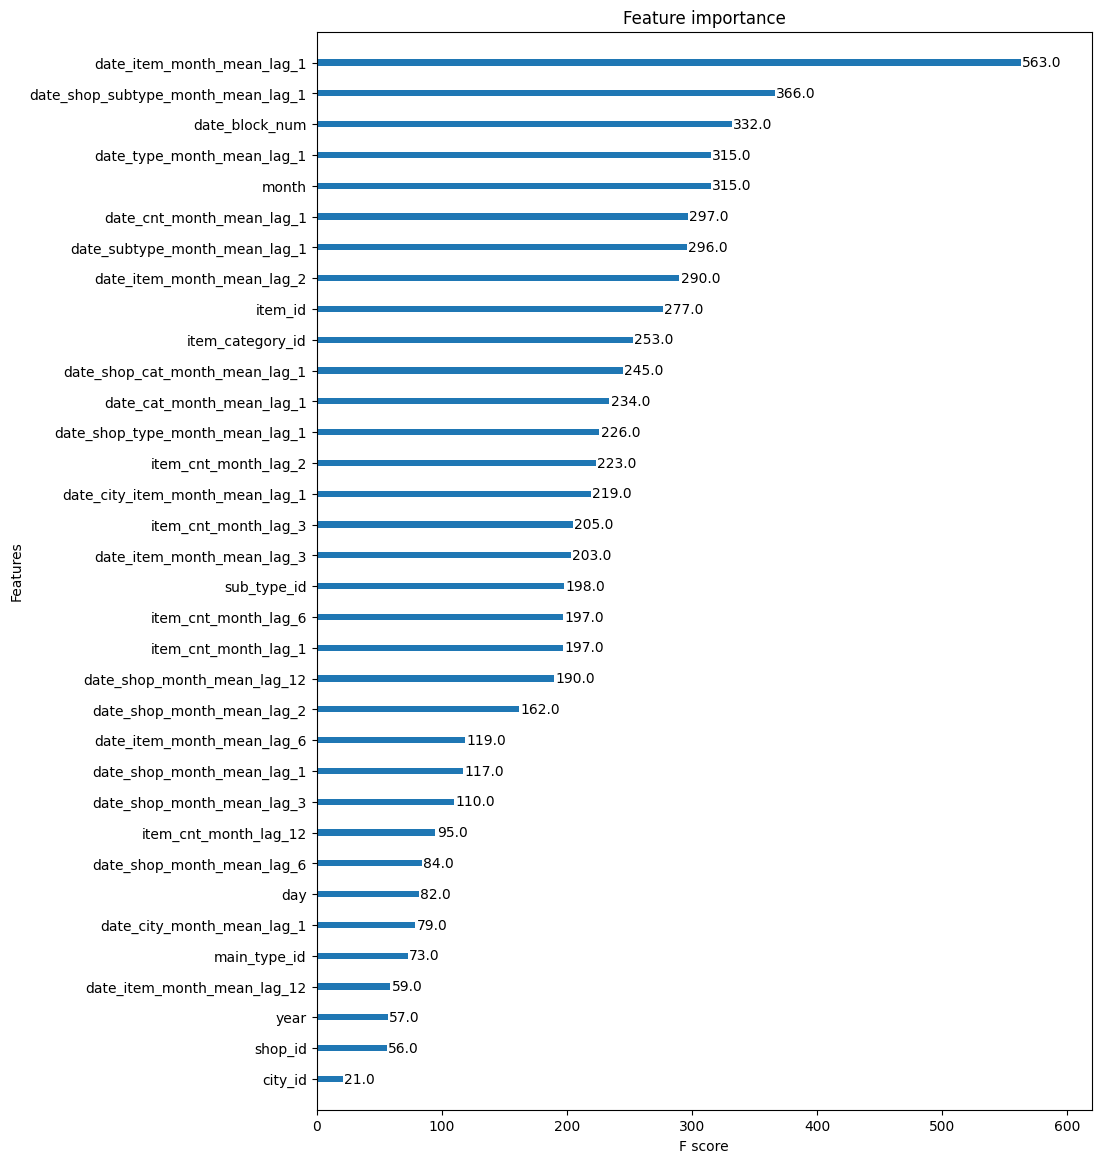

In [38]:
# xgboost의 plot_important 함수를 불러와 모델의 feature 중요도를 찍어봄
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(model, importance_type='weight', ax=ax, grid=False)
# 트리에서 각 feature가 사용된 횟수를 그래프 시각화, 자주 사용될수록 높은 중요도를 부여
# importance_type = 'default(weight)'

In [9]:
submit = pd.DataFrame({'ID':test['ID'], 'item_cnt_month':y_test})
submit

,ID,item_cnt_month
0,0,0.715860
1,1,0.057791
2,2,1.180311
3,3,0.547514
4,4,0.408281
...,...,...
214195,214195,0.124551
214196,214196,0.046634
214197,214197,0.091790
214198,214198,0.056249


In [10]:
submit.to_csv('../future_sales_xgb_submission.csv', index=False)

In [ ]:
# 제출 결과
# -----------------------------------------
    # max_depth = 8,
    # n_estimators = 500,
    # learning_rate = 0.1,
    # min_child_weight = 200,
    # colsample_bytree = 0.6,
    # subsample = 0.8,
    # gamma = 0.5,
    # eta = 0.1,
    # eval_metric = 'rmse',
    # early_stopping_rounds = 20,
    # seed = 42
                # Validation_RMSE : 0.86835 
                # Submission_RMSE : 0.99457
# -----------------------------------------
    # eval_metric = 'rmse',
    # early_stopping_rounds = 20,
    # seed = 42
                # Validation_RMSE : 0.87369 
                # Submission_RMSE : 1.00117
# -----------------------------------------
    # max_depth = 7,
    # n_estimators = 500,
    # min_child_weight = 300,
    # colsample_bytree = 0.6,
    # subsample = 0.8,
    # eta = 0.1,
    # eval_metric = 'rmse',
    # early_stopping_rounds = 20,
    # seed = 42
                # Validation_RMSE : 0.87027 
                # Submission_RMSE : 1.00088
# -----------------------------------------
    # max_depth = 8,
    # n_estimators = 500,
    # min_child_weight = 300,
    # colsample_bytree = 0.8,
    # subsample = 0.8,
    # eta = 0.3,
    # eval_metric = 'rmse',
    # early_stopping_rounds = 20,
    # seed = 42
                # Validation_RMSE : 0.86963 
                # Submission_RMSE : 1.00088
# -----------------------------------------                
    # max_depth = 8,
    # n_estimators = 500,
    # min_child_weight = 300,
    # colsample_bytree = 0.6,
    # subsample = 0.8,
    # eta = 0.1,
    # eval_metric = 'rmse',
    # early_stopping_rounds = 10,
    # seed = 42
                # Validation_RMSE : 0.86683 
                # Submission_RMSE : 0.99722